In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import numpy as np
import pickle
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from pygam import LinearGAM, s, f
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
def pickleLoad(file):
    with open(file,"rb") as fr:
        dataframe = pickle.load(fr)
    return dataframe

In [3]:
%run -i './getTrainTestSet/getTrainTestSet_median.py' 

In [4]:
# load train, test set data
X_train = pickleLoad('./dataset/dataset_median/X_train.pkl')
X_test = pickleLoad('./dataset/dataset_median/X_test.pkl')
y_train = pickleLoad('./dataset/dataset_median/y_train.pkl')
y_test = pickleLoad('./dataset/dataset_median/y_test.pkl')
ccsi = pickleLoad('./dataset/dataset_median/ccsi.pkl')
predictors = pickleLoad('./dataset/dataset_median/predictors.pkl')

* data preprocessing(standard scaling)

In [5]:
########## 변수 스케일링
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### model 1. multiple linear regression

* 10-fold CV

In [6]:
model_lr = LinearRegression()
scores = cross_val_score(model_lr, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error')
rmse_linearRegressionCV = np.sqrt(-scores)
rmse_lravg = rmse_linearRegressionCV.mean()
rmse_lrstd = rmse_linearRegressionCV.std()

In [7]:
print(" 10-fold cv RMSE: ", rmse_linearRegressionCV)
print("최종 CV RMSE = ", rmse_lravg)

 10-fold cv RMSE:  [4.93638626 1.30546915 6.25527339 2.3099854  3.40760996 2.21712166
 3.69562377 2.49003832 3.28079174 5.1097573 ]
최종 CV RMSE =  3.50080569595515


### model 2: Random Forest

In [8]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [9]:
# CV
rmse_randomforest, parameters_randomforest = [], []
numOfEstimators = np.power(2, [3,4,5,6])
maxFeatures = [1,2,3,4,5]
for i in maxFeatures:
    for j in numOfEstimators:
        # parameter search
        model_forest = RandomForestRegressor(max_features = i, n_estimators = j, warm_start = True, random_state = 23)
        parameters_randomforest.append(model_forest.get_params)
        # 10-fold CV
        scores = cross_val_score(model_forest, X_train, y_train, cv = k_fold, scoring = 'neg_mean_squared_error')
        rmse_randomforest.append(np.sqrt(-scores))
    

In [10]:
def getCVResult(rmse_list, model_num):
    cv_rmse =  rmse_list[model_num - 1].mean()
    std = rmse_list[model_num - 1].std()

    return cv_rmse, std

In [11]:
rmse_list, std_list = [], []
for i in range(1,21):
    cv_rmse, std = getCVResult(rmse_randomforest, i)
    rmse_list.append(cv_rmse)
    std_list.append(std)
    print(i, cv_rmse, std)
    

1 2.665355412049596 1.0005904800206384
2 3.034563403357649 1.0154550578139627
3 3.056977944736664 0.8518500980420478
4 2.9650429438755705 0.9452301251077407
5 3.0867516498989906 1.286962036384858
6 3.096727092988031 1.155340378277718
7 2.9018941180538493 0.903576433598434
8 2.825660185956642 0.9075846956665075
9 3.011971587263363 0.7449657928510606
10 2.9186192727007505 0.7014236485674953
11 2.726214628231232 0.6457476529471717
12 2.623144689424702 0.6974113160909663
13 2.509937566402848 0.5989086222118843
14 2.532762682657439 0.6331056496749848
15 2.580644834194117 0.6844229959633588
16 2.5078082059864384 0.6065222520414796
17 2.54717597270218 0.8125875154952233
18 2.490620830568168 0.8415639896362176
19 2.5077984749388986 0.769406308075671
20 2.5159697705949764 0.6892012386371432


#### final random forest model selection

In [12]:
rmse_list.index(min(rmse_list))

17

model 후보 1~20번 중에, 18번모델이 가장 낮은 rmse 평균값을 갖고있음을 확인할 수 있다.

따라서, 18번 모델을 랜덤포레스트 대표모델로 활용하고자 한다.

In [13]:
# 대표 모델의 파라미터
parameters_randomforest[rmse_list.index(min(rmse_list))]

<bound method BaseEstimator.get_params of RandomForestRegressor(max_features=5, n_estimators=16, random_state=23,
                      warm_start=True)>

In [14]:
# 대표 모델의 평균 rmse와 std
rmse_forestavg = rmse_list[rmse_list.index(min(rmse_list))]
rmse_foreststd = std_list[rmse_list.index(min(rmse_list))]

In [15]:
# 대표 모델의 10-fold cv
rmse_randomforestCV = rmse_randomforest[rmse_list.index(min(rmse_list))]
rmse_randomforestCV

array([4.28681208, 2.00019335, 1.52147389, 2.4585549 , 2.46278552,
       2.35682188, 2.15393445, 1.28842124, 2.94009028, 3.43712072])

In [16]:
print(" 10-fold cv RMSE: ", rmse_randomforestCV)
print("최종 CV RMSE = ", rmse_forestavg)

 10-fold cv RMSE:  [4.28681208 2.00019335 1.52147389 2.4585549  2.46278552 2.35682188
 2.15393445 1.28842124 2.94009028 3.43712072]
최종 CV RMSE =  2.490620830568168


### model 3: GAM

In [17]:
X_train = pd.DataFrame(X_train, columns = ['keyword1', 'keyword2', 'keyword3', 'keyword4', 'keyword5', 'google', 'naver'])

In [18]:
# CV
rmse_gamCV = []
np.random.seed(1)
lams = np.random.rand(100, 7) # random points on [0, 1], with shape (100, 3)
lams = lams * 6 - 3 # shift values to -3, 3
lams = 10 ** lams # transforms values to 1e-3, 

K=10
for k in range(K):
    if k < 3:
        val_ind = (range(4 * k, 4 * k + 4))
    else:
        val_ind = (range(5 * (k-1)+1, 5 * (k-1)+6))
    X_train2 = X_train.drop(val_ind).to_numpy()
    y_train2 = y_train.drop(val_ind).to_numpy()
    X_val = X_train.loc[val_ind, :].to_numpy()
    y_val = y_train.loc[val_ind, :].to_numpy()
    # parameter search
    model_gam =  LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5)+ s(6)).gridsearch(X_train2, y_train2, lam = lams)
    y_hat = model_gam.predict(X_val)
    scores = mean_squared_error(y_val, y_hat)
    rmse_gamCV.append(np.sqrt(scores))
    
    

100% (100 of 100) |######################| Elapsed Time: 0:00:12 Time:  0:00:12
100% (100 of 100) |######################| Elapsed Time: 0:00:11 Time:  0:00:11
100% (100 of 100) |######################| Elapsed Time: 0:00:11 Time:  0:00:11
100% (100 of 100) |######################| Elapsed Time: 0:00:11 Time:  0:00:11
100% (100 of 100) |######################| Elapsed Time: 0:00:11 Time:  0:00:11
100% (100 of 100) |######################| Elapsed Time: 0:00:11 Time:  0:00:11
100% (100 of 100) |######################| Elapsed Time: 0:00:11 Time:  0:00:11
100% (100 of 100) |######################| Elapsed Time: 0:00:10 Time:  0:00:10
100% (100 of 100) |######################| Elapsed Time: 0:00:10 Time:  0:00:10
100% (100 of 100) |######################| Elapsed Time: 0:00:13 Time:  0:00:13


In [19]:
rmse_gamavg = np.mean(rmse_gamCV)
rmse_gamstd = np.std(rmse_gamCV)

In [20]:
print(" 10-fold cv RMSE: ", rmse_gamCV)
print("최종 CV RMSE = ", rmse_gamavg)

 10-fold cv RMSE:  [10.894199984811912, 9.232502768565272, 4.117071228935434, 3.880750971699699, 5.900419833792756, 7.580274677170307, 7.865005695756486, 11.334463031331433, 5.2464832870303075, 3.863477210999691]
최종 CV RMSE =  6.991464869009329


### model 4: Lasso Regression

In [21]:
# CV
rmse_lasso, parameters_lasso = [], []
alpha = [10, 1, 0.1, 0.01, 0.001]
for i in alpha:
    # parameter search
    model_lasso = Lasso(alpha = i, random_state = 23)
    parameters_lasso.append(model_lasso.get_params)
    # 10-fold CV
    scores = cross_val_score(model_lasso, X_train, y_train, cv = k_fold, scoring = 'neg_mean_squared_error')
    rmse_lasso.append(np.sqrt(-scores))
    

In [22]:
rmse_list, std_list = [], []
for i in range(1, 6):
    cv_rmse, std = getCVResult(rmse_lasso, i)
    rmse_list.append(cv_rmse)
    std_list.append(std)
    print(i, cv_rmse, std)

1 5.738183320169615 1.2898070743884191
2 3.239349613715236 0.6049223416949302
3 2.7396036493563445 1.0190051972156962
4 2.7002221812260223 1.0572733250600945
5 2.693533915991976 1.065857754328604


#### final lasso linear regression model selection

In [23]:
rmse_list.index(min(rmse_list))

4

model 후보 1~5번 중에, 5번모델이 가장 낮은 rmse 평균값을 갖고 있음을 확인할 수 있다.

따라서, 5번 모델을 랜덤포레스트 대표모델로 활용하고자 한다.

In [24]:
# 대표 모델의 파라미터
parameters_lasso[rmse_list.index(min(rmse_list))]

<bound method BaseEstimator.get_params of Lasso(alpha=0.001, random_state=23)>

In [25]:
# 대표 모델의 평균 rmse와 std
rmse_lassoavg = rmse_list[rmse_list.index(min(rmse_list))]
rmse_lassostd = std_list[rmse_list.index(min(rmse_list))]

In [26]:
# 대표 모델의 10-fold cv
rmse_lassoCV = rmse_lasso[rmse_list.index(min(rmse_list))]
rmse_lassoCV 

array([4.10511113, 1.42764983, 2.839441  , 2.11977176, 2.68514486,
       3.2074862 , 1.58641731, 1.51858801, 2.62160219, 4.82412687])

###  Model간 CV RMSE 비교

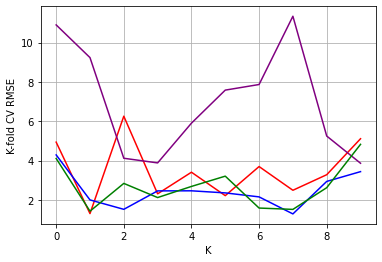

In [27]:
plt.plot(rmse_linearRegressionCV, color = 'red', label = 'Linear Regression')
plt.plot(rmse_randomforestCV, color = 'blue', label = 'Random Forest')
plt.plot(rmse_gamCV, color = 'purple', label = 'Generalized Additive Models')
plt.plot(rmse_lassoCV, color = 'green', label = 'Lasso Linear Regression')
plt.xlabel("K")
plt.ylabel("K-fold CV RMSE")
plt.grid(True)

In [28]:
print(rmse_lravg, rmse_forestavg, rmse_gamavg, rmse_lassoavg)

3.50080569595515 2.490620830568168 6.991464869009329 2.693533915991976


## T-test

In [29]:
def tTest(rmse1, rmse2):
    mean = (rmse1 - rmse2).mean()
    sd = (rmse1 - rmse2).std()
    t_statistic = mean / (sd / np.sqrt(10))
    return t_statistic

**H0**: linear regression model의 rmse = Random Forest model의 rmse<br>
즉, 두 모델의 성능에 차이가 없다.<br><br>
**H1**: 두 모델의 성능에 차이가 있다.

In [30]:
mean = np.average(rmse_linearRegressionCV - rmse_randomforestCV)
sd = (rmse_linearRegressionCV - rmse_randomforestCV).std()

tTest(rmse_linearRegressionCV, rmse_randomforestCV)

2.21617721372669

In [31]:
print(rmse_linearRegressionCV - rmse_randomforestCV)
print(mean)

[ 0.64957418 -0.6947242   4.7337995  -0.14856949  0.94482445 -0.13970022
  1.54168932  1.20161708  0.34070146  1.67263658]
1.010184865386982


t_0.025,9 = 2.262 <br><br>

|t-value| = 2.216 < t_0.025,9 이므로, 유의수준 0.05에서 귀무가설이 기각되지않는다. 따라서, linear regression model과 Random forest model의 성능에는 차이가 없다. 


**H0**: linear regression model의 rmse = GAM model의 rmse<br>
즉, 두 모델의 성능에 차이가 없다.<br><br>
**H1**: 두 모델의 성능에 차이가 있다.

In [32]:
mean = np.average(rmse_linearRegressionCV - rmse_gamCV)
sd = np.std(rmse_linearRegressionCV - rmse_gamCV)

tTest(rmse_linearRegressionCV, rmse_gamCV)

-3.1928084263460907

In [33]:
print(rmse_linearRegressionCV - rmse_gamCV)
print(mean)

[-5.95781372 -7.92703362  2.13820217 -1.57076557 -2.49280987 -5.36315302
 -4.16938193 -8.84442471 -1.96569155  1.24628008]
-3.49065917305418


t_0.025,9 = 2.262 <br><br>

|t-value| = 3.193 > t_0.025,9 이므로, 유의수준 0.05에서 귀무가설이 기각된다.  따라서, linear regression model과 GAM model의 성능에는 차이가 있다. 이때 linear와 GAM의 cv rmse값을 뺀것이 음수이기때문에, linear의 rmse가 GAM의 rmse보다 작다. 즉, **linear 모델이 성능이 좋다. **



**H0**: linear regression model의 rmse = Lasso linear regression model의 rmse<br>
즉, 두 모델의 성능에 차이가 없다.<br><br>
**H1**: 두 모델의 성능에 차이가 있다.

In [34]:
mean = np.average(rmse_linearRegressionCV - rmse_lassoCV)
sd = (rmse_linearRegressionCV - rmse_lassoCV).std()

tTest(rmse_linearRegressionCV, rmse_lassoCV) 

2.2131972775407163

t_0.025,9 = 2.262 <br><br>

|t-value| = 2.213 < t_0.025,9 이므로, 유의수준 0.05에서 귀무가설이 기각되지않는다. 따라서, linear regression model과 Lasso linear regression model의 성능에는 차이가 없다. 

**H0**: Random Forest model의 rmse = GAM model의 rmse<br>
즉, 두 모델의 성능에 차이가 없다.<br><br>
**H1**: 두 모델의 성능에 차이가 있다.

In [35]:
mean = np.average(rmse_randomforestCV - rmse_gamCV)
sd = (rmse_randomforestCV - rmse_gamCV).std()

tTest(rmse_randomforestCV, rmse_gamCV)

-5.023001320197163

In [36]:
print(rmse_randomforestCV - rmse_gamCV)
print(mean)

[ -6.6073879   -7.23230942  -2.59559733  -1.42219607  -3.43763432
  -5.2234528   -5.71107125 -10.04604179  -2.30639301  -0.42635649]
-4.500844038441161


t_0.025,9 = 2.262 <br><br>

|t-value| = 5.023 > t_0.025,9 이므로, 유의수준 0.05에서 귀무가설이 기각된다. 따라서, random forest model과 GAM model의 성능에는 차이가 있다. 이때 rf와 GAM의 cv rmse값을 뺀것이 음수이기때문에, rf의 rmse가 GAM의 rmse보다 작다. 즉, **rf 모델이 성능이 좋다. **


**H0**: Random Forest model의 rmse = Lasso linear regression model의 rmse<br>
즉, 두 모델의 성능에 차이가 없다.<br><br>
**H1**: 두 모델의 성능에 차이가 있다.

In [37]:
mean = np.average(rmse_randomforestCV - rmse_lassoCV)
sd = (rmse_randomforestCV - rmse_lassoCV).std()

tTest(rmse_randomforestCV, rmse_lassoCV)

-0.9098013938119408

In [38]:
print(rmse_randomforestCV - rmse_lassoCV)
print(mean)

[ 0.18170095  0.57254352 -1.3179671   0.33878314 -0.22235934 -0.85066432
  0.56751714 -0.23016677  0.31848809 -1.38700615]
-0.20291308542380784


t_0.025,9 = 2.262 <br><br>

|t-value| = 0.910 < t_0.025,9 이므로, 유의수준 0.05에서 귀무가설이 기각되지않는다. 따라서, random forest model과 Lasso linear regression model의 성능에는 차이가 없다.


**H0**: GAM model의 rmse = Lasso linear regression model의 rmse<br>
즉, 두 모델의 성능에 차이가 없다.<br><br>
**H1**: 두 모델의 성능에 차이가 있다.

In [39]:
mean = np.average(rmse_gamCV - rmse_lassoCV)
sd = (rmse_gamCV - rmse_lassoCV).std()

tTest(rmse_gamCV, rmse_lassoCV)

4.29657915861939

In [40]:
print(rmse_gamCV - rmse_lassoCV)
print(mean)

[ 6.78908885  7.80485293  1.27763023  1.76097921  3.21527498  4.37278847
  6.27858839  9.81587502  2.6248811  -0.96064966]
4.297930953017355


t_0.025,9 = 2.262 <br><br>

|t-value| = 4.297 > t_0.025,9 이므로, 유의수준 0.05에서 귀무가설이 기각된다. 따라서, GAM model과 lasso linear regression model의 성능에는 차이가 있다. 이때 GAM과 lasso의 cv rmse값을 뺀것이 양수이기때문에, lasso의 rmse가 GAM의 rmse보다 작다. 즉, **lasso 모델이 성능이 좋다. **

#### 6번의 T-검정 결과, 해당 데이터 분할 방법에서는 <br>
1. max_features=5, n_estimators=16, random_state=23, warm_start=True 파라미터의 random forest<br>
2. linear regression<br>
3. alpha=0.001, random_state = 23 파라미터의 lasso linear regression

가 비슷한 성능으로 좋게나온다. 따라서 test RMSE, MAE기준으로 선택하겠다.

## Testing

* model 1: rf
* model 2: linear
* model 3: lasso

In [41]:
# 최종 선택 모델 재적합
model_final1 = RandomForestRegressor(max_features = 5, n_estimators = 16, warm_start = True, random_state = 23)
model_final1.fit(X_train, y_train)

model_final2 = LinearRegression()
model_final2.fit(X_train, y_train)

model_final3 = Lasso(alpha = 0.001, random_state = 23)
model_final3.fit(X_train, y_train)

Lasso(alpha=0.001, random_state=23)

In [42]:
y_pred1 = model_final1.predict(X_test)
y_pred2 = model_final2.predict(X_test)
y_pred3 = model_final3.predict(X_test)

* model evaluating

In [43]:
print("R square: ", model_final1.score(X_train, y_train))
print("training RMSE: ", np.sqrt(mean_squared_error(y_train, model_final1.predict(X_train))))
print("test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred1)))
print("training MAE: ", np.sqrt(mean_absolute_error(y_train, model_final1.predict(X_train))))
print("test MAE: ", np.sqrt(mean_absolute_error(y_test, y_pred1)))

R square:  0.9666730006401344
training RMSE:  1.034188008515146
test RMSE:  13.226469254199772
training MAE:  0.903796341045346
test MAE:  3.3228219683475877


In [44]:
print("R square: ", model_final2.score(X_train, y_train))
print("training RMSE: ", np.sqrt(mean_squared_error(y_train, model_final2.predict(X_train))))
print("test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred2)))
print("training MAE: ", np.sqrt(mean_absolute_error(y_train, model_final2.predict(X_train))))
print("test MAE: ", np.sqrt(mean_absolute_error(y_test, y_pred2)))

R square:  0.8281685171638146
training RMSE:  2.3482955772695457
test RMSE:  9.347243968932013
training MAE:  1.381316885810508
test MAE:  2.6064048522733634


In [45]:
print("R square: ", model_final3.score(X_train, y_train))
print("training RMSE: ", np.sqrt(mean_squared_error(y_train, model_final3.predict(X_train))))
print("test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred3)))
print("training MAE: ", np.sqrt(mean_absolute_error(y_train, model_final3.predict(X_train))))
print("test MAE: ", np.sqrt(mean_absolute_error(y_test, y_pred3)))

R square:  0.8281679269752998
training RMSE:  2.348299610104118
test RMSE:  9.336012761430782
training MAE:  1.3814888008388073
test MAE:  2.6051384913746563


## Step5. Visulization
### weekly record 예측하기(weekly CCSI)

In [46]:
# scaling(X_train에 했던 scaling을 그대로 적용)
X = scaler.transform(predictors.loc[:, ['keyword1', 'keyword2', 'keyword3', 'keyword4', 'keyword5', 'google', 'naver']])

In [47]:
# weekly 레코드들을 예측모델에 집어넣어, 각 레코드에 대한 예측값 얻음
pred_ccsi1 = model_final1.predict(X)
pred_ccsi2 = model_final2.predict(X)
pred_ccsi3 = model_final3.predict(X)

In [48]:
tmp = pd.merge(predictors, ccsi)
tmp['pred1'] = pred_ccsi1
tmp['pred2'] = pred_ccsi2
tmp['pred3'] = pred_ccsi3
tmp.head()

,year,month,day,keyword1,keyword2,keyword3,keyword4,keyword5,google,naver,id,ccsi,pred1,pred2,pred3
0,2016,1,4,825,419,437,986,168,53.0,26.05846,5,99.5,97.26875,104.018465,103.995239
1,2016,1,11,770,348,351,626,182,58.0,25.16599,5,99.5,98.38750,102.801074,102.785348
2,2016,1,18,918,422,441,445,147,74.0,27.38639,5,99.5,94.66875,94.198503,94.189796
3,2016,1,25,1067,425,567,383,148,59.0,24.72622,5,99.5,94.34375,87.954624,87.956822
4,2016,2,1,899,341,485,289,110,63.0,23.01888,6,97.2,93.40625,93.387929,93.385480


In [49]:
# weekly별 단기지표 값에 대한 RMSE
print("RMSE about weekly CCSI: ", np.sqrt(mean_squared_error(tmp['ccsi'], tmp['pred1'])))
print("RMSE about weekly CCSI: ", np.sqrt(mean_squared_error(tmp['ccsi'], tmp['pred2'])))
print("RMSE about weekly CCSI: ", np.sqrt(mean_squared_error(tmp['ccsi'], tmp['pred3'])))

RMSE about weekly CCSI:  6.6605262597668435
RMSE about weekly CCSI:  5.873385829508128
RMSE about weekly CCSI:  5.866951375044959


### visaulization
* 시계열 그래프

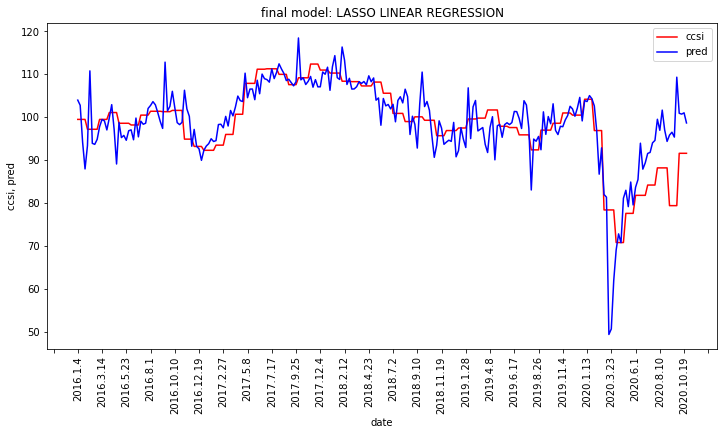

In [50]:
# 시계열 그래프를 그리기위해, 날짜 column 생성
tmp['date'] = tmp[['year', 'month', 'day']].apply(lambda x: '.'.join(map(str, x)), axis=1)

plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(tmp['date'], tmp['ccsi'], color = 'red', label = 'ccsi')
plt.plot(tmp['date'], tmp['pred3'], color = 'blue', label = 'pred')
plt.xlabel("date")
plt.ylabel("ccsi, pred")
ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(90)
plt.title("final model: LASSO LINEAR REGRESSION")
plt.legend()
plt.show()

* moving avg 시계열 그래프

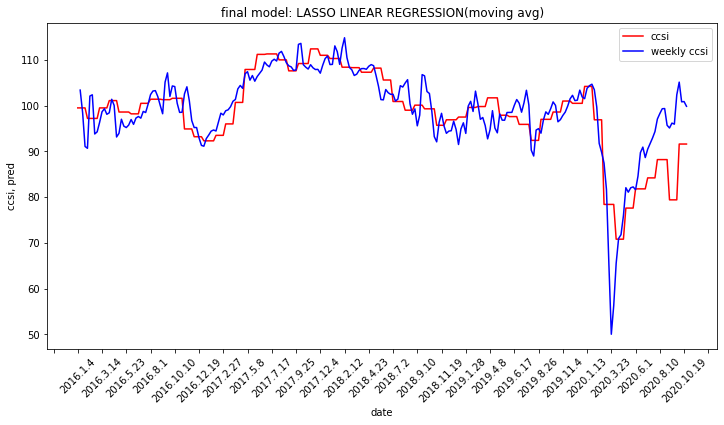

In [51]:
rolling = pd.Series.rolling(tmp['pred3'], window = 2, center = False).mean()

plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(tmp['date'], tmp['ccsi'], color = 'red', label = 'ccsi')
rolling.plot(color = 'blue', label = 'weekly ccsi')
plt.xlabel("date")
plt.ylabel("ccsi, pred")
ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(45)
plt.title("final model: LASSO LINEAR REGRESSION(moving avg)")
plt.legend()
plt.show()

2주 간의 단기 지표들을 평균낸 값을 weekly CCSI로 활용하고자함. <br>
시각화 결과, 주간 레코드에 대한 예측 결과를 바로 활용하는 것 보다 2주 간의 예측 결과 평균을 활용하는 것이 덜 들쑥날쑥하다.

## Step6. Develop weekly CCSI(주간 경기선행지수)

In [52]:
weekly_CLI = []
for i in range(len(tmp)):
    if i == 0 :
        cli = tmp.pred3.iloc[i]
        weekly_CLI.append(cli)
        continue
    
    cli = (tmp.pred3.iloc[i-1] + tmp.pred3.iloc[i]) / 2
    weekly_CLI.append(cli)
    
tmp['weeklyCLI'] = weekly_CLI
tmp[['date', 'weeklyCLI']]

,date,weeklyCLI
0,2016.1.4,103.995239
1,2016.1.11,103.390294
2,2016.1.18,98.487572
3,2016.1.25,91.073309
4,2016.2.1,90.671151
...,...,...
247,2020.9.28,102.358954
248,2020.10.5,105.134870
249,2020.10.12,100.831302
250,2020.10.19,100.882978
